In [ ]:
import components
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import logging

# initialize logger with function
streamHandler = components.loggerConfig()

change fastly between different options:

In [9]:
case = 0

if case == 0:
    import components.ChaDepLimCon as chargingStationClass
    useOnlyOneChargingStation = True
    useChargingStation = 0
elif case ==1:
    import components.ChaDepMpcBase as chargingStationClass
    useOnlyOneChargingStation = False
    useChargingStation = 0
elif case ==2:
    import components.ChaDepMpcBase as chargingStationClass
    useOnlyOneChargingStation = True
    useChargingStation = 0

### simulation

#### initialize helper objects for simulation
- SimulationBroker
- VehicleGenerator
- ResultWriter

In [ ]:
# simulation broker
path_Sim = "test_data/beam1/beam1-0.csv"
dtype_Sim = {
       'time': 'int64', 'type': 'category', 'vehicle': 'int64', 'parkingTaz': 'category','chargingPointType': 'category', 
       'primaryFuelLevel': 'float64', 'mode': 'category', 'currentTourMode': 'category', 'vehicleType': 'category', 
       'arrivalTime': 'float64', 'departureTime': 'float64', 'linkTravelTime': 'string', 'primaryFuelType': 'category', 
       'parkingZoneId': 'category','duration': 'float64' 
        }
SimBroker = components.SimBroker(path_Sim, dtype_Sim)
logging.info("SimBroker initialized")

# vehicle generator
path_DataBase = "test_data/vehicleFiles/vehicletypes-Base_2035_20210204_updated.csv"
VehicleGenerator = components.VehicleGenerator(path_Sim, dtype_Sim, path_DataBase)
logging.info("VehicleGenerator initialized")

sim_name = "sim1"
result_directory = "results"
ResultWriter = components.ResultWriter(result_directory, sim_name)
logging.info("ResultWriter initialized")

In [ ]:
# show head of vehicles dataframe
VehicleGenerator.vehicles.head(3)

#### create charging stations
1) map parkingZoneIds to charging stations with a dictionary
2) create charging Stations

In [5]:
# load infrastructure file into dataframe
from re import L


path_infrastructure = "test_data/beam1/gemini-base-scenario-3-charging-no-household-infra16.csv"
usecols_infrastructure = ["taz", "parkingType",
                          "chargingPointType", "parkingZoneId"]
dtype_infrastructure = {"taz": "int64", "parkingType": "category",
                        "chargingPointType": "category", "parkingZoneId": "string"}
infrastructure = pd.read_csv(
    path_infrastructure, dtype=dtype_infrastructure, usecols=usecols_infrastructure)
infrastructure = infrastructure.set_index("parkingZoneId")
# filter infrastructure for only public fast and extreme fast charging
infrastructure = infrastructure.loc[infrastructure["parkingType"] == "Public"]
infrastructure = infrastructure.loc[infrastructure["chargingPointType"].str.contains(
    "publicfc|publicxfc")]
infrastructure = infrastructure.sort_values(by=["taz", "parkingZoneId"])

# now, make a dict of every parkingZoneId that belongs to a charging station
# here, we will split the chargingstation
chargingStationMappedToParkingZoneId = {}
chargingStationMappedToTaz = {}
stepsize = 200
i = 0
j = 1
stop = False
while i < len(infrastructure) - 1:
    name = "chargingStation-" + str(j)
    # we want to make sure, that all the chargingBays of one TAZ are in one chargingStation
    if i + stepsize < len(infrastructure):
        i_end = i+stepsize
        while infrastructure.iloc[i_end]["taz"] == infrastructure.iloc[i_end+1]["taz"]:
            i_end += 1  # if the taz is the same, we should increase reading to that taz
            # make sure, that we don't try to read in the next step something that doesnt exist
            if i_end + 1 >= len(infrastructure) - 1:
                stop = True
                break
    else:
        i_end = len(infrastructure)-1
    if not stop:
        i_end += 1  # to also catch the last element
    slice = infrastructure.iloc[i:i_end]
    chargingStationMappedToParkingZoneId[name] = slice.index.to_list()
    chargingStationMappedToTaz[name] = list(
        set(slice["taz"].to_list()))  # this removes duplicates
    i = i_end  # start reading next cycle at i
    j += 1

# we convert chargingStationMappedToTaz to a dataframe to use search methods
chargingStationMappedToTaz = pd.DataFrame.from_dict(
    chargingStationMappedToTaz, orient='index')
chargingStationMappedToTaz = chargingStationMappedToTaz.transpose()

logging.info("charging stations mapped to parkingZoneId")

# #here, we will make chargingStation depending on TAZ. Therefore, get a list of the different TAZ and sort it:
# taz = infrastructure.taz.drop_duplicates().to_list()
# taz = sorted(taz)
# while i < len(taz):
#     name = "chargingStation-" + str(j)
#     # slice = infrastructure.loc[infrastructure["taz"].isin(taz[i:i+stepsize])]
#     chargingStationMappedToParkingZoneId[name] = slice.index.to_list()
#     i += stepsize
#     j += 1


2022-09-19 14:59:26,454 : root  : <module> : INFO : charging stations mapped to parkingZoneId


In [ ]:
infrastructure.head(3)

In [ ]:
chargingStationMappedToTaz.head(3)

here, charging stations are created. please specifiy the type of charging station you want to use

In [6]:
#create chargingStations
logging.info("creating charging stations of type " + str(chargingStationClass))

chargingStations = []  # list of charging stations
for i in chargingStationMappedToParkingZoneId:
    #chargingStations.append(i)

    ChargingStationId = i
    # make a list with the power of each charging bay:
    ChBaMaxPower = []
    for j in chargingStationMappedToParkingZoneId[i]:
        power_string = infrastructure.loc[j, "chargingPointType"]
        ChBaMaxPower.append(components.chargingCapFromString(power_string))

    # for now, we assume that all charging bays have the same charging power
    PowerMax = max(ChBaMaxPower)
    len_power = len(ChBaMaxPower)
    ChBaMaxPower = []
    # make charging limit for each bay the same (for testing and simplicity)
    for j in range(0, len_power):
        ChBaMaxPower.append(PowerMax)
    del PowerMax, len_power

    ChBaParkingZoneId = chargingStationMappedToParkingZoneId[i]
    calcBtmsGridProp = True

    '''reduce number of charging bays to test controller'''
    # numStations = 30
    # ChBaMaxPower = ChBaMaxPower[0:numStations]
    ChBaNum = len(ChBaMaxPower)

    # create charging station
    container = chargingStationClass(ChargingStationId=ChargingStationId, ResultWriter=ResultWriter, SimBroker=SimBroker,
                                     ChBaMaxPower=ChBaMaxPower, ChBaParkingZoneId=ChBaParkingZoneId, ChBaNum=ChBaNum, calcBtmsGridProp=True)
    chargingStations.append(container)
    logging.info(ChargingStationId + " was created with " + str(container.ChBaNum) +
          " charging bays and " + str(container.BtmsSize) + "kWh BTM-Storage")

2022-09-19 14:59:32,023 : root  : <module> : INFO : creating charging stations of type <class 'components.ChaDepLimCon.ChaDepLimCon'>
2022-09-19 14:59:32,033 : root  : <module> : INFO : chargingStation-1 was created with 208 charging bays and 26000.0kWh BTM-Storage
2022-09-19 14:59:32,038 : root  : <module> : INFO : chargingStation-2 was created with 207 charging bays and 25875.0kWh BTM-Storage
2022-09-19 14:59:32,042 : root  : <module> : INFO : chargingStation-3 was created with 93 charging bays and 11625.0kWh BTM-Storage


- initialize helper objects for simulation input

In [7]:
PhySimDummy = components.PhySimDummy(chargingStations)
logging.info("PhySimDummy initialized")
DermsDummy  = components.DermsDummy(chargingStations)
logging.info("DermsDummy initialized")

2022-09-19 14:59:41,010 : root  : <module> : INFO : PhySimDummy initialized
2022-09-19 14:59:41,012 : root  : <module> : INFO : DermsDummy initialized


#### initialize simulation
initialize Grid Constraints and actual time of charging Station

In [10]:
#reduce number of chargingStation for testing
if useOnlyOneChargingStation:
    chargingStations = [chargingStations[useChargingStation]]
    logging.info('we reduced the number of charging stations to 1')

2022-09-19 15:00:24,641 : root  : <module> : INFO : we reduced the number of charging stations to 1


In [11]:
'''Simulation settings:'''
timestep = 5 * 60  # in seconds
logging.info("timestep is set to " + str(timestep) + " seconds")

2022-09-19 15:00:27,751 : root  : <module> : INFO : timestep is set to 300 seconds


In [12]:
for x in chargingStations:
    GridPowerLower, GridPowerUpper = DermsDummy.output(x.ChargingStationId)
    x.initialize(GridPowerLower = GridPowerLower, GridPowerUpper = GridPowerUpper)
    logging.info(str(x.ChargingStationId) + " initialized with DermsDummy output")
    # TODO is this necessary in the way this is set up? updated before vehicle arrival!

2022-09-19 15:00:29,072 : root  : <module> : INFO : chargingStation-1 initialized with DermsDummy output


generate predictions for power use of charging station

In [13]:
if chargingStationClass == components.ChaDepMpcBase:
    # TODO: for testing we dont add noise
    for x in chargingStations:
        x.generatePredictions(path_BeamPredictionFile = path_Sim, dtype = dtype_Sim, path_DataBase = path_DataBase, timestep = timestep, addNoise = True)
        logging.info("generated predictions for " + str(x.ChargingStationId))

plot prediction 

In [14]:
if chargingStationClass == components.ChaDepMpcBase:
    x = chargingStations[0]
    time = x.PredictionTime
    power = x.PredictionPower

    ax = plt.subplot()
    ax.plot(time,power, label = 'with noise')
    ax.plot(time,x.power_sum_original, label = 'without noise')
    ax.legend()
plt.show()

BTMS size optimization

see mpcBase.md for explanations

In [15]:
if chargingStationClass == components.ChaDepMpcBase:
    logging.info("starting btms size optimization")
    a = 20/30 * ((SimBroker.t_max - SimBroker.t_act)/3.6e3) / \
        24       # demand charge per day
    # free power, after which demand charge is applied, as ratio to avg power
    P_free_Ratio = 0
    # btms cost per cycle per kWh (price per kWh/ possible cycles)
    b = 300/5000
    c = 0.15      # electricity cost per kWh

    Print = False
    Graph = True
    for i in range(0, len(chargingStations)):
        logging.info("optimizing btms size for " + str(chargingStations[i].ChargingStationId))
        x = chargingStations[i]
        # determine P_free
        avgPower = sum(x.PredictionPower*timestep) / \
            (max(x.PredictionTime) + timestep - min(x.PredictionTime))
        P_free = P_free_Ratio * avgPower

        # btms size optimization
        time, time_x, btms_size, P_Grid, P_BTMS, P_BTMS_Ch, P_BTMS_DCh, E_BTMS, P_Charge, cost = x.determineBtmsSize(
            SimBroker.t_act, SimBroker.t_max, timestep, a, b, c, P_free)

        # we set the max and min soc to 1 and 0
        x.BtmsMaxSoc = 1.0
        x.BtmsMinSoc = 0.0

        time = time/3.6e3  # conversion to hours
        time_x = time_x/3.6e3

        #print('\n', x.ChargingStationId)
        str1 = 'Optimization with free power level of {:.2f} kW'.format(P_free)
        str2 = ' and a demand charge of {:.2f} €/day*kW'.format(a)
        str3 = ' and a BTMS cost of {:.5f} €/kWh'.format(b)
        str4 = ' and an electricity cost of {:.3f} €/kWh'.format(c)
        #print(str1, str2, str3, str4)
        logging.info(str1 + str2 + str3 + str4)
        str1 = 'The determined effective BTMS size is {:.2f} kWh.'.format(btms_size)
        str2 = ' The total cost is {:.2f} €.'.format(cost)
        cRating = max(abs(P_BTMS))/btms_size
        str3 = 'The associated C-Rating is {:.2f}'.format(cRating)
        #print(str1, str2, str3)
        logging.info(str1 + str2 + str3)
        # btmsDCh is always negative
        costLoss = c*(sum(P_BTMS_Ch*timestep/3.6e3) +
                        sum(P_BTMS_DCh*timestep/3.6e3))
        costCycle = b*sum(P_BTMS_Ch*timestep/3.6e3)
        # convert the upper code in the new format
        str1 = 'The cost-value is ${:.2f}'.format(cost) + ' from which ${:.2f}'.format(a*(max(P_Grid)-P_free)) + ' is associated with demand charge, ${:.2f}'.format(costCycle) + ' is associated with BTMS degradation and ${:.2f}'.format(costLoss) + ' is associated with energy losses'
        print(str1)
        logging.info(str1)
        E_total = sum(timestep/3.6e3*P_Charge)
        str1 = 'The total delivered energy to the vehicles is {:.2f} kWh, which results in an average power of {:.2f} kW'.format(E_total, E_total/(max(time)-min(time) + timestep/3.6e3))
        str2 = '{:.2f} kWh were delivered by the BTMS and charging losses of {:.2f} kWh occured.'.format(-sum(P_BTMS_DCh*timestep/3.6e3), sum(P_BTMS_DCh*timestep/3.6e3) + sum(P_BTMS_Ch*timestep/3.6e3))
        str3 = 'The maximal grid power is {:.2f} kW'.format(max(P_Grid))
        #print(str1, str2, str3)
        logging.info(str1 + str2 + str3)

        if Graph:
            cRating = max(abs(P_BTMS))/btms_size
            E_total = sum(timestep/3.6e3*P_Charge)
            avgPower = int(E_total/(max(time)-min(time) + timestep/3.6e3))
            # usage factor, how many cycles btms is discharged
            useFactor = -sum(P_BTMS_DCh*timestep/3.6e3) / btms_size
            # we also define a usage factor as fraction of energy by btms and compare to the total charged energy
            btmsSupport = btms_size / sum(P_Charge*timestep/3.6e3)
            # btmsDCh is always negative
            costLoss = c*(sum(P_BTMS_Ch*timestep/3.6e3) +
                          sum(P_BTMS_DCh*timestep/3.6e3))
            costCycle = b*sum(P_BTMS_Ch*timestep/3.6e3)
            costDemand = a*(max(P_Grid)-P_free)
            info_string1 = 'free power: ' + str(int(P_free)) + 'kW \navg power: ' + str(int(avgPower)) + 'kW \nmax power: ' + str(int(max(P_Grid))) + 'kW \nBTMS-size: ' + str(int(btms_size)) + 'kWh \nC-Rating: ' + "{:.2f}".format(
                cRating) + ' \nuseFactor: ' + "{:.2f}".format(useFactor) + ' \nbtmsSupport: ' + "{:.2f}".format(btmsSupport) + ' \n\ncost: $' + str(int(cost)) + ' \ndemand: $' + str(int(costDemand)) + '\ncycle: $' + str(int(costCycle)) + '\nloss: $' + str(int(costLoss))

            fig, ax = plt.subplots(2, 1, sharex=True)

            ax[0].plot(time_x, E_BTMS, label="Energy_BTMS [kWh]")
            ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
            fig.text(-0.12, 0, info_string1, horizontalalignment='right', verticalalignment='center',
                     multialignment='left', transform=ax[0].transAxes, bbox=dict(facecolor='none', edgecolor='grey', pad=5.0))
            #ax[0].text(0.5, 1, info_string2, horizontalalignment='right', verticalalignment='top', transform=ax[0].transAxes)

            ax[1].step(time, P_BTMS, label="P_BTMS [kW]")
            ax[1].step(time, P_Grid, label="P_Grid [kW]")
            ax[1].step(time, P_Charge, label="P_Charge [kW]")
            ax[1].axhline(0, color='black')
            ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
            ax[1].set_xlabel("time in [h]")

            print(cost)


further reduce btms size with a factor

In [16]:
if chargingStationClass == components.ChaDepMpcBase:
    factor = 1.0
    for x in chargingStations:
        x.BtmsSize = factor * x.determinedBtmsSize
        x.BtmsMaxPower= factor * x.determinedMaxPower
        if factor != 1.0:
            logging.info(x.ChargingStationId + ' btms size was changed to {:.2f} kWh and max power to {:.2f} kW with a factor of {:.2f}'.format(x.BtmsSize, x.BtmsMaxPower, factor))

In [17]:
# save charging Station properties
'''write charging station properties to ResultWriter'''
ResultWriter.saveChargingStationProperties(chargingStations)
logging.info('Charging station properties saved')

2022-09-19 15:01:03,582 : root  : <module> : INFO : Charging station properties saved


create optimal day-ahead plan

planning() (MPC Base - convex)

In [18]:
if chargingStationClass == components.ChaDepMpcBase:
    logging.info('creating day ahead plan')
    a = 50/30 * ((SimBroker.t_max - SimBroker.t_act)/3.6e3) / \
        24  # demand charge cost
    # free power, after which demand charge is applied, as ratio to avg power
    P_free_Ratio = 0
    b = 300/5000                    # btms degradation cost
    c = 0.15                        # electricity cost
    d_param = 10                    # waiting time cost of a vehicle in $/h
    P_chAvg = 100                   # average charging speed in kW of an vehicle
    beta = 0.15                     # bandwith for energy level curve
    # if choosen different from None, constraints to enforce c rate are applied
    cRating = None
    Graph = True
    if cRating == None:
        cPrint = ', cRating not enforced'
    else:
        cPrint = ", cRating = {:.2f}".format(cRating)

    logging.info("parameters for creating day ahead plan: demand charge cost = {:.2f}, free power ratio = {:.2f}, btms degradation cost = {:.2f}, electricity cost = {:.2f}, waiting time cost = {:.2f}, average charging speed = {:.2f}, beta = {:.2f}".format(a, P_free_Ratio, b, c, d_param, P_chAvg, beta) + cPrint)

    if True:  # make a time varying d-vector
        x = chargingStations[0]
        time = np.array(x.PredictionTime)
        power = np.array(x.PredictionPower)
        idx = np.logical_and(time >= SimBroker.t_act, time <= SimBroker.t_max)
        time_new = time[idx]
        d = d_param  # transformed to list by .planning() function
        #d = []
        # for i in range(0,sum(idx)):
        # for time varying vector
        # if time_new[i]< 21800:
        #     d.append(1)
        # elif time_new[i] < 26000:
        #     d.append(10)
        # elif time_new[i] < 28000:
        #     d.append(1)
        # elif time_new[i] < 29500:
        #     d.append(10)
        # else:
        #     d.append(2)
        # d.append(d_param)
        #logging.info('added time varying d-vector: ' + str(d))

    for x in chargingStations:
        logging.info("Creating Day Ahead plan for " + x.ChargingStationId)
        avgPower = sum(x.PredictionPower*timestep) / \
            (max(x.PredictionTime) + timestep - min(x.PredictionTime))
        P_free = P_free_Ratio * avgPower

        time, time_x, P_Grid, P_BTMS, P_BTMS_Ch, P_BTMS_DCh, E_BTMS, E_Shift, P_Charge, P_Shift, t_wait_val, cost_t_wait, cost = x.planning(
            SimBroker.t_act, SimBroker.t_max, timestep, a, b, c, d, P_free, P_chAvg, beta, cRating)

        if Graph:
            cRating = max(abs(P_BTMS))/x.BtmsSize
            E_total = sum(timestep/3.6e3*P_Charge)
            avgPower = int(E_total/(max(time)-min(time) + timestep/3.6e3))
            useFactor = -sum(P_BTMS_DCh*timestep/3.6e3) / x.BtmsSize
            btmsSupport = x.BtmsSize / E_total
            # btmsDCh is always negative
            costLoss = c*(sum(P_BTMS_Ch*timestep/3.6e3) +
                          sum(P_BTMS_DCh*timestep/3.6e3))
            costCycle = b*sum(P_BTMS_Ch*timestep/3.6e3)
            costDemand = a*(max(P_Grid)-P_free)

            info_string1 = 'free power: ' + str(int(P_free)) + 'kW \navg power: ' + str(int(avgPower)) + 'kW \nmax power: ' + str(int(max(P_Grid))) + 'kW \nBTMS-size: ' + str(int(x.BtmsSize)) + 'kWh \nC-Rating: ' + "{:.2f}".format(cRating) + ' \nuseFactor: ' + "{:.2f}".format(
                useFactor) + ' \nbtmsSupport: ' + "{:.2f}".format(btmsSupport) + ' \n\ncost: $' + str(int(cost)) + ' \ndemand: $' + str(int(costDemand)) + '\ncycle: $' + str(int(costCycle)) + '\nloss: $' + str(int(costLoss)) + '\nwait: $' + str(int(cost_t_wait))
            logging.info(info_string1)

            fig, ax = plt.subplots(3, 1, sharex=True)
            ax[0].plot(time_x, E_BTMS, label="Energy_BTMS [kWh]")
            ax[0].plot(time_x, E_Shift, label="shifted Energy [kWh]")
            ax[0].axhline(x.BtmsSize, label="BTMS size[kWh]",
                          color="black", linestyle="--")
            ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
            fig.text(-0.12, 0, info_string1, horizontalalignment='right', verticalalignment='center',
                     multialignment='left', transform=ax[0].transAxes, bbox=dict(facecolor='none', edgecolor='grey', pad=5.0))
            #ax[0].text(0.5, 1, info_string2, horizontalalignment='right', verticalalignment='top', transform=ax[0].transAxes)

            ax[1].step(time, P_BTMS, label="P_BTMS [kW]")
            ax[1].step(time, P_Grid, label="P_Grid [kW]")
            ax[1].step(time, P_Charge-P_Shift, label="P_Charge [kW]")
            ax[1].step(time, P_Charge, label="P_Charge optimal [kW]")
            ax[1].step(time, P_Shift, label="P_Shift [kW]")
            ax[1].axhline(0, color='black')
            ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

            if sum(t_wait_val) < 0.0005:
                t_wait_val = np.zeros_like(t_wait_val)
            ax[2].step(time, t_wait_val*60, label="waiting time [min]")
            ax[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))

            ax[2].set_xlabel("time in [h]")

            fig.set_size_inches(7, 6*3/3)

            #TODO: add flexible electricity prices - what happens then?


#### run simulation

In [40]:
SimBroker.reset()
ResultWriter.reset()
# charging station is not resetted

# charging station BtmsEn and P_GridLast was initialized in planning()-function

# determine iterations for progress bar
max_iter = np.ceil((SimBroker.SimRes.index[-1] - SimBroker.SimRes.index[0])/timestep)
# print maximum iterations
logging.info("\n-------\nstarting simulation.\n-------\n maximum iterations: " + str(max_iter))

# change logging level to WARNING
streamHandler.setLevel(logging.WARNING)

#initialize progress bar
progress_bar = tqdm(desc = "MPC simulation", total=max_iter)

while not SimBroker.eol():
    # update progress bar
    progress_bar.update(1)
    
    # Sim Broker Step
    slice = SimBroker.step(timestep)
    logging.info("\n-|-|-|-|-|\ntimestep to {:.0f}s / {:.0f}s | iteration: {:.0f}".format(SimBroker.t_act, SimBroker.t_max, SimBroker.iteration))

    #update values from DERMS and PhysicalSimulation
    for x in chargingStations:
        # update SiteNet Power Limits from Derms
        GridPowerLower, GridPowerUpper = DermsDummy.output(x.ChargingStationId)
        x.updateFromDerms(GridPowerLower, GridPowerUpper)
        logging.info("update GridPowerLimits from Derms: {:.0f}kW - {:.0f}kW".format(GridPowerLower, GridPowerUpper))
        # update CES SOC from PhysicalSimulation
        x.updateFromPhySim(PhySimDummy.output(x.ChargingStationId))
        logging.info("update CES SOC from PhySim: {:.0f}kWh".format(PhySimDummy.output(x.ChargingStationId)))

    # generate Vehicles if charging Plug in event
    logging.info("adding vehicles of slice to charging stations")
    for i in range(0, len(slice)):
        if slice.iloc[i]["type"] == "ChargingPlugInEvent":
            # generate vehicle
            vehicle = VehicleGenerator.generateVehicleSO(slice.iloc[i])
            # let vehicle arrive at a charging station - here depending on taz
            taz = int(slice.iloc[i]["parkingTaz"]) # this is a str
            #find out which chargingStation belongs to the taz
            res = chargingStationMappedToTaz.isin([taz]).any().values
            index = np.where(res == True)[0][0]

            #let vehicles arrive at designated chargingStation
            if useOnlyOneChargingStation:
                if index == useChargingStation:
                    chargingStations[index].arrival(vehicle, SimBroker.t_act)
            else: 
                chargingStations[index].arrival(vehicle, SimBroker.t_act)

    ## control action and simulation
    
    # call step function
    for x in chargingStations:
        logging.info("--- calling .step() charging station %s | iteration %s | connected vehicles %s  ---" % (x.ChargingStationId, str(SimBroker.iteration), str(len(x.ChBaVehicles) - x.ChBaVehicles.count(False))))
        if isinstance(x, components.ChaDepMpcBase):
            x.step(timestep)
        else:
            x.step(timestep)
        logging.info("--- finished .step() charging station %s | iteration %s | connected vehicles %s---" % (x.ChargingStationId, str(SimBroker.iteration), str(len(x.ChBaVehicles) - x.ChBaVehicles.count(False))))
    
    # provide outputs
    for x in chargingStations:
        PhySimDummy.input(x.ChargingStationId, sum(x.ChBaPower), x.P_BTMS, timestep)
        DermsDummy.input(x.ChargingStationId, x.PowerDesire)

progress_bar.close()

# change logging level back to INFO
streamHandler.setLevel(logging.INFO)

logging.info("Simulation terminated. final number of iterations: {:.0f}, final time: {:.0f}s".format(SimBroker.iteration, SimBroker.t_act))
    

MPC simulation:  26%|██▌       | 11/42.0 [00:05<00:15,  2.02it/s]
MPC simulation: 100%|██████████| 42/42.0 [15:14<00:00, 21.77s/it]

2022-09-19 15:27:36,030 : root  : <module> : INFO : Simulation terminated. final number of iterations: 41, final time: 30763s


In [20]:
print("actual Iteration: " + str(SimBroker.iteration))
print("actual time: " + str(SimBroker.t_act))

actual Iteration: 41
actual time: 30763


In [21]:
showVehicle = 0

In [22]:

print("current time: ", SimBroker.t_act)
print(chargingStations[0].ChBaVehicles[showVehicle])
print("\nVehicle Number in ChBa: ", showVehicle)
if chargingStations[0].ChBaVehicles[showVehicle] != False:
    lower, upper = chargingStations[0].ChBaVehicles[showVehicle].getChargingTrajectories(SimBroker.t_act, timestep, 10)
    fig, ax = plt.subplots(1,1)
    plt.plot(lower, label="lower bound")
    plt.plot(upper, label= "upper bound")
    plt.legend()
    ax.set_xlabel("control steps")
    ax.set_ylabel("energy [kWh]")

showVehicle += 1

current time:  30763
False

Vehicle Number in ChBa:  0


#### sneak peak into results

In [23]:
df3 = ResultWriter.ChargingStationStates
df3.head(3)

,time,ChargingStationID,BaysVehicleIds,BaysChargingPower,TotalChargingPower,BaysChargingDesire,BaysNumberOfVehicles,QueueVehicleIds,QueueChargingDesire,QueueNumberOfVehicles,...,BtmsSoc,BtmsEnergy,TotalChargingPowerDesire,GridPower,GridPowerUpper,GridPowerLower,PowerDesire,BtmsPowerDesire,EnergyLagSum,TimeLagSum
0,18463,chargingStation-1,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,[],[],0,...,0.500000,13000.00,0,0.0,104000.0,-104000.0,0,0,0,0
1,18763,chargingStation-1,[1545605],"[174.49999999999997, 0, 0, 0, 0, 0, 0, 0, 0, 0...",174.5,"[0.9561643835616437, nan, nan, nan, nan, nan, ...",1,[],[],0,...,0.500913,13023.75,0,0.0,104000.0,-104000.0,0,26000.0,0,0
2,19063,chargingStation-1,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,[],[],0,...,0.501827,13047.50,0,0.0,104000.0,-104000.0,0,26000.0,0.0,0


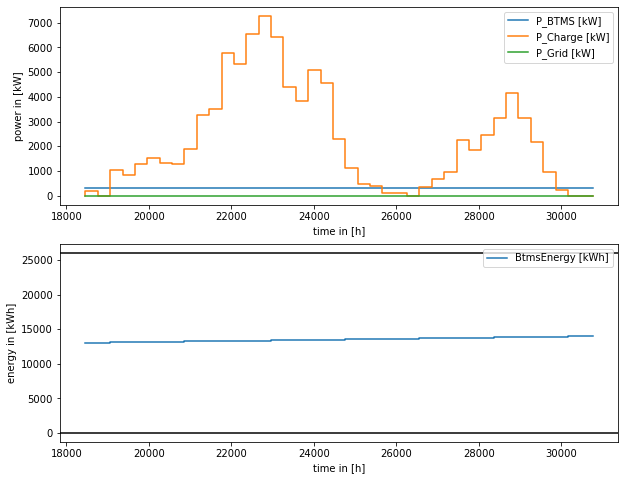

In [25]:
# plot charging and btms power
Station = "chargingStation-1"
df4 = ResultWriter.ChargingStationStates.loc[ResultWriter.ChargingStationStates.ChargingStationID==Station]
fig, ax = plt.subplots(2,1)
ax[0].step(df4["time"], df4["BtmsPower"], label="P_BTMS [kW]")
ax[0].step(df4["time"], df4["TotalChargingPower"], label="P_Charge [kW]")
ax[0].step(df4["time"], df4["GridPower"], label="P_Grid [kW]")
ax[0].legend()
if isinstance(chargingStationClass, components.ChaDepMpcBase):
    ax[0].axhline(chargingStations[0].P_GridMaxPlanning, color = 'black')
ax[0].set_xlabel("time in [h]")
ax[0].set_ylabel("power in [kW]")

ax[1].step(df4["time"], df4["BtmsEnergy"], label="BtmsEnergy [kWh]")
ax[1].axhline(ResultWriter.chargingStationProperties.loc[ResultWriter.chargingStationProperties.ChargingStationId == Station].BtmsSize.values[0], color='black')
ax[1].axhline(0, color='black')
ax[1].set_xlabel("time in [h]")
ax[1].set_ylabel("energy in [kWh]")
ax[1].legend()

fig.set_size_inches(10,8)

In [27]:
VehicleStates = ResultWriter.VehicleStates.loc[ResultWriter.VehicleStates.VehicleId == 6506887.0]
VehicleStates.head(40)

,time,VehicleId,ChargingStationId,QueueOrBay,ChargingPower,possiblePower,ChargingDesire,VehicleDesiredEnd,VehicleEnergy,VehicleDesiredEnergy,VehicleSoc,EnergyLag,TimeLag
31,20263,6506887,chargingStation-1,Bay,150.0,150.0,1.045455,20769,45.10866,67.150326,0.537303,-0.958333,0
42,20563,6506887,chargingStation-1,Bay,114.5,114.5,1.111650,20769,57.60866,67.150326,0.686194,-0.958333,-206


In [28]:
VehicleEvents = ResultWriter.Events.loc[ResultWriter.Events.VehicleId == 6506887.0]
VehicleEvents.head(40)

,time,Event,ChargingStationId,VehicleId,QueueOrBay,ChargingDesire,VehicleType,VehicleArrival,VehicleDesiredEnd,VehicleEnergy,VehicleDesiredEnergy,VehicleSoc,VehicleMaxEnergy,VehicleMaxPower,ChargingBayMaxPower
67,20263,ArrivalEvent,chargingStation-1,6506887,,1.045455,ev-L1-0-to-50000-LowTech-2035-SUV-BEV_300,20240,20769,45.108660,67.150326,0.537303,83.953903,150.0,NaN
72,20263,ReparkEvent,chargingStation-1,6506887,Bay,1.045455,ev-L1-0-to-50000-LowTech-2035-SUV-BEV_300,20240,20769,45.108660,67.150326,0.537303,83.953903,150.0,250.0
101,20563,ReleaseEvent,chargingStation-1,6506887,,NaN,ev-L1-0-to-50000-LowTech-2035-SUV-BEV_300,20240,20769,67.150326,67.150326,0.799848,83.953903,150.0,NaN


In [29]:
checkIteration = 7
newDf = pd.DataFrame([df3.loc[checkIteration].BaysChargingPower, df3.loc[checkIteration].BaysChargingDesire, df3.loc[checkIteration].BaysVehicleIds]).T
newDf.columns = ["BaysChargingPower", "BaysChargingDesire", "BaysVehicleIds"]
newDf.head(25)

,BaysChargingPower,BaysChargingDesire,BaysVehicleIds
0,143.0,7.729730,2219095.0
1,39.0,inf,7032990.0
2,150.0,1.919540,1856277.0
3,150.0,1.204061,881117.0
4,169.5,1.017000,3940494.0
5,150.0,1.388889,1638187.0
6,100.5,1.296774,2606571.0
7,121.5,0.659729,2460922.0
8,136.5,0.670762,2089510.0
9,114.5,1.111650,6506887.0


In [30]:
ResultWriter.chargingStationProperties

,ChargingStationId,BtmsSize,BtmsC,BtmsMaxPower,BtmsMaxSoc,BtmsMinSoc,ChBaNum,ChBaMaxPower,ChBaMaxPower_abs,ChBaParkingZoneId,GridPowerMax_Nom
0,chargingStation-1,26000.0,1,26000.0,0.8,0.2,208,"[250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250...",250.0,"[X-PEV-9-1, X-PEV-11-1, X-PEV-12-1, X-PEV-21-1...",18200.0


In [31]:
ResultWriter.MpcStats.head(6)

,time,ChargingStationID,Status,Iterations,OptimalValue,SetupTime,SolveTime,SolverName,sum_t1,sum_t2,T1,T2


#### save results

In [32]:
ResultWriter.save()

#### plot results

(4420.000000000002, 23090.600000000002)
2022-09-19 15:06:21,967 : root  : <module> : INFO : figure printed


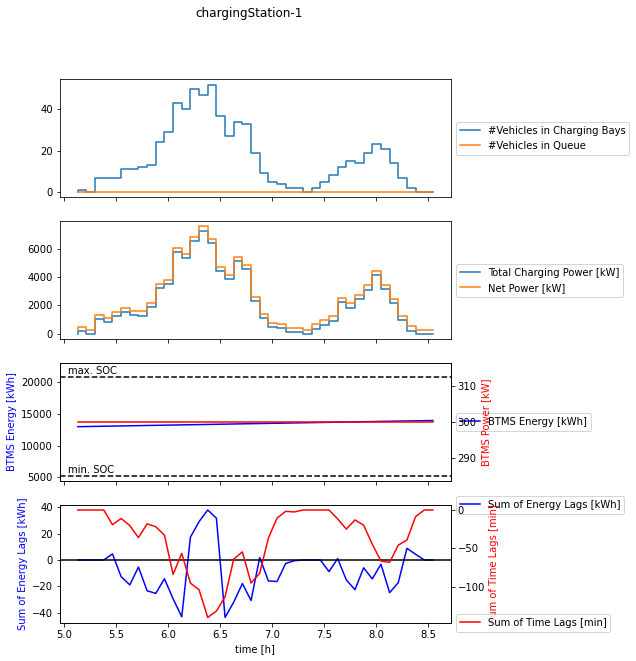

In [38]:
import matplotlib.pyplot as plt
loadDataFromFile = False
plotChargingStation = 0

if loadDataFromFile == True:
    # need to add code to load this from file
    pass
else:
    ChSt = ResultWriter.ChargingStationStates.loc[ResultWriter.ChargingStationStates.ChargingStationID ==
                                                  chargingStations[plotChargingStation].ChargingStationId]

fig, ax = plt.subplots(4, 1, sharex=True)
fig.suptitle(chargingStations[plotChargingStation].ChargingStationId)
ax[0].step(ChSt.time/3600, ChSt.BaysNumberOfVehicles,
           label="#Vehicles in Charging Bays")
ax[0].step(ChSt.time/3600, ChSt.QueueNumberOfVehicles,
           label="#Vehicles in Queue")
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
# ax[0].grid()

#ax[1].step(ChSt.time/3600, ChSt.GridPowerUpper, label = "Upper Power Limit [kW]")
ax[1].step(ChSt.time/3600, ChSt.TotalChargingPower,
           label="Total Charging Power [kW]")

ax[1].step(ChSt.time/3600, ChSt.TotalChargingPower +
           ChSt.BtmsPower, label="Net Power [kW]")
if isinstance(chargingStationClass, components.ChaDepMpcBase):
    ax[1].axhline(chargingStations[0].P_GridMaxPlanning, color = 'black', label = 'P_Max_Planning [kW]') # TODO need to save P Grid Max Planning
#ax[1].step(ChSt.time/3600, ChSt.BtmsPower, label = "Net Power [kW]")
if isinstance(chargingStationClass, components.ChaDepMpcBase):
    ax[1].step(np.array(chargingStations[0].PredictionTime)/3600, chargingStations[0].PredictionPower , label="unconstrained Power [kW]")
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
# ax[1].grid()

ax[2].plot(ChSt.time/3600, ChSt.BtmsEnergy,
           label="BTMS Energy [kWh]", color="blue")
ax[2].set_ylabel("BTMS Energy [kWh]", color="blue")
if case == 2 or case == 3:
    ax[2].plot(ChSt.time/3600, chargingStations[plotChargingStation].E_BtmsLower[0:np.shape(
        ChSt.time)[0]], color='grey', label="lower bound planning")
    ax[2].plot(ChSt.time/3600, chargingStations[plotChargingStation].E_BtmsUpper[0:np.shape(
        ChSt.time)[0]], color='grey', label="upper bound planning")

y1 = chargingStations[plotChargingStation].BtmsSize * \
    chargingStations[plotChargingStation].BtmsMaxSoc
ax[2].axhline(y=y1, linestyle="--", color="black")

y2 = chargingStations[plotChargingStation].BtmsSize * \
    chargingStations[plotChargingStation].BtmsMinSoc
ax[2].axhline(y=y2, linestyle="--", color="black")
# ax[2].grid()

ylim = ax[2].get_ylim()
ax[2].set_ylim([ylim[0], 1.07*ylim[1]])
ylim = ax[2].get_ylim()
print(ylim)
dy = ylim[1]-ylim[0]
xlim = ax[2].get_xlim()
x = xlim[0]
dx = xlim[1]-xlim[0]
ax[2].text(x+0.02*dx, y1+0.03*dy, "max. SOC")
ax[2].text(x+0.02*dx, y2+0.03*dy, "min. SOC")

ax1 = ax[2].twinx()
ax1.step(ChSt.time/3600, ChSt.BtmsPower, label="BTMS Power [kW]", color="red")
ax1.set_ylabel("BTMS Power [kW]", color="red")
#ax1.set_ylim([-chargingStations[plotChargingStation].GridPowerMax_Nom,chargingStations[plotChargingStation].GridPowerMax_Nom])
ax[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax[3].plot(ChSt.time/3600, ChSt.EnergyLagSum,
           label="Sum of Energy Lags [kWh]", color="blue")
if isinstance(chargingStationClass, components.ChaDepMpcBase):
    ax[3].plot(ChSt.time/3600, chargingStations[0].PredictionEnergyLag, label="Prediction Energy Lags [kWh]", color="mediumslateblue")
ax[3].axhline(y=0, color="black")
ax[3].set_ylabel("Sum of Energy Lags [kWh]", color="blue")
#ax[3].legend(loc= 'center left', bbox_to_anchor=(1, 0.5))

ax2 = ax[3].twinx()
ax2.plot(ChSt.time/3600, ChSt.TimeLagSum/60,
         label="Sum of Time Lags [min]", color="red")
if isinstance(chargingStationClass, components.ChaDepMpcBase):
    ax2.plot(ChSt.time/3600, np.array(chargingStations[0].PredictionTimeLag)/60, label="Prediction Time Lags [min]", color="orangered")
ax2.set_ylabel("Sum of Time Lags [min]", color="red")

ax[3].set_xlabel("time [h]")
ax[3].legend(loc = 'center left', bbox_to_anchor=(1, 1))
ax2.legend(loc = 'center left', bbox_to_anchor=(1, 0))

fig.set_size_inches(7, 10)
logging.info("figure printed")
